In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


# 1. Load data

In [3]:
# alldata = np.load('processed_endomondoHR_proper_interpolate.npy', allow_pickle=True)

In [4]:
alldata = []
for i in range(10 + 1):
    alldata.extend(np.load('subDataset/processedData{}.npy'.format(i), allow_pickle=True))

In [5]:
len(alldata)

102992

# 2. data analysis

In [6]:
countType = defaultdict(int)

In [7]:
for sample in alldata:
    countType[sample['sport']] += 1

In [8]:
countType = sorted(countType.items(), key = lambda x: -x[1])

In [9]:
name = []
counts = []
for k,v in countType:
    name.append(k)
    counts.append(v)

In [10]:
countType

[('bike', 48493),
 ('run', 39201),
 ('mountain bike', 7711),
 ('bike (transport)', 3234),
 ('indoor cycling', 1320),
 ('cross-country skiing', 630),
 ('walk', 618),
 ('orienteering', 553),
 ('core stability training', 258),
 ('hiking', 193),
 ('fitness walking', 186),
 ('roller skiing', 158),
 ('skate', 124),
 ('kayaking', 60),
 ('circuit training', 53),
 ('rowing', 46),
 ('weight training', 31),
 ('downhill skiing', 24),
 ('soccer', 21),
 ('snowshoeing', 15),
 ('golf', 11),
 ('horseback riding', 7),
 ('tennis', 5),
 ('treadmill running', 5),
 ('badminton', 5),
 ('climbing', 5),
 ('basketball', 4),
 ('swimming', 4),
 ('table tennis', 3),
 ('rugby', 3),
 ('snowboarding', 2),
 ('elliptical', 2),
 ('gymnastics', 1),
 ('aerobics', 1),
 ('sailing', 1),
 ('kite surfing', 1),
 ('squash', 1),
 ('stair climing', 1),
 ('martial arts', 1)]

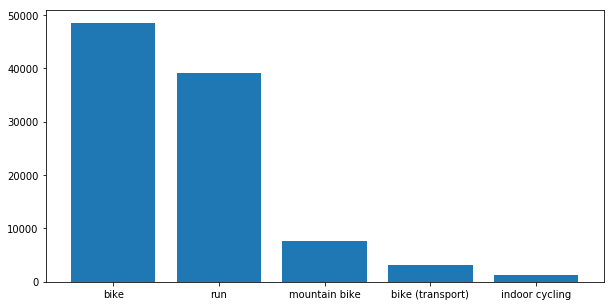

In [11]:
numOfSport = 5
plt.figure(figsize = (10,5))
plt.bar(name[:numOfSport], counts[:numOfSport])
# plt.title("The MSE  vs different lambda", fontsize=18)
# plt.xlabel("lambda", fontsize=18)
# plt.ylabel("MSE", fontsize=18)
# plt.legend()
# plt.tick_params(labelsize=15)
plt.show()
# bestIndex = np.argmin(MSEs_total)
# print('we can see the smallest MSE is {:.4f} with lambda {:.5f}.'\
#       .format(MSEs_total[bestIndex], lambs_total[bestIndex]))

In [12]:
# np.save('processedData.npy', data, allow_pickle=True)

In [13]:
# for sportType in name:
#     print(sportType)
#     with open('subDataset/'+sportType+'DataSet.json','w') as outfile:
#         for sample in data:
#             if sample['sport'] == sportType:   
# #                 print(type(sample))
#                 json.dump(sample,outfile,ensure_ascii=False)
#                 outfile.write('\n')


# 3. class and feature selection

In [31]:
UsedClass = name[:5]
# weight = sum(counts[:5])/ torch.tensor(counts[:5]).float()

In [32]:
UsedClass

['bike', 'run', 'mountain bike', 'bike (transport)', 'indoor cycling']

In [69]:
labelIndex = dict()
for i, sport in enumerate(UsedClass):
    labelIndex[sport] = i
def feature(sample, lenOfSeq = 5):
    featureList = []
    featureList.append(labelIndex[sample['sport']])
    featureList.extend([1,0] if sample['gender'] == 'male' else [0,1])
    
    inputFeat = []
    inputFeat.append(sample['heart_rate'][::lenOfSeq])
    inputFeat.append(sample['longitude'][::lenOfSeq])
    inputFeat.append(sample['latitude'][::lenOfSeq])
    inputFeat.append(sample['altitude'][::lenOfSeq])
    inputFeat.append(sample['distance'][::lenOfSeq])
#     inputFeat.append(sample['derived_speed'][::lenOfSeq])    
    featureList.append(list(zip(*inputFeat)))
    return featureList

In [70]:
data = [feature(sample) for sample in alldata if sample['sport'] in UsedClass]

In [71]:
train_data, val_test_data = train_test_split(data, test_size=1/5)
val_data, test_data = train_test_split(val_test_data, test_size=1/2)

In [72]:
XTrainGender = np.array([sample[1:3] for sample in train_data], dtype= 'float32')
XTrainSeq = np.array([sample[3] for sample in train_data], dtype= 'float32')
XTrain = [XTrainGender, XTrainSeq]
YTrain = np.array([sample[0] for sample in train_data])


XTestGender = torch.from_numpy(np.array([sample[1:3] for sample in test_data], dtype= 'float32')).cuda()
XTestSeq = torch.from_numpy(np.array([sample[3] for sample in test_data], dtype= 'float32')).cuda()
XTest = [XTestGender, XTestSeq]
YTest = torch.from_numpy(np.array([sample[0] for sample in test_data]))

# XTest = torch.from_numpy(test_data[:,1:]).cuda()
# YTest = torch.from_numpy(test_data[:,0])


XValGender = np.array([sample[1:3] for sample in val_data], dtype= 'float32')
XValSeq = np.array([sample[3] for sample in val_data], dtype= 'float32')
XVal = [XValGender, XValSeq]
YVal = np.array([sample[0] for sample in val_data])



In [73]:
# class sportDataset(td.Dataset):
#     def __init__(self, X, Y): # initialize
#         super(sportDataset, self).__init__() # initialize the superclass
#         self.X = X
#         self.Y = Y.astype('int64')
#     def __len__(self):
#         return len(self.Y) # return the size of dataset
#     def __getitem__(self, idx):
#         x = [self.X[0][idx], self.X[1][idx]] # do transformation
#         d = self.Y[idx] # get label
#         return x, d # return data and label
#     def number_of_classes(self):
#         return self.Y.max() + 1 # return the number of classes
class sportDataset(td.Dataset):
    def __init__(self, X, Y): # initialize
        super(sportDataset, self).__init__() # initialize the superclass
        self.XGender = X[0]
        self.XSeq = X[1]
        self.Y = Y.astype('int64')
    def __len__(self):
        return len(self.Y) # return the size of dataset
    def __getitem__(self, idx):
        xgender, xseq = self.XGender[idx], self.XSeq[idx]
        d = self.Y[idx] # get label
        return xgender, xseq, d # return data and label
    def number_of_classes(self):
        return self.Y.max() + 1 # return the number of classes

In [74]:
train_set = sportDataset(XTrain, YTrain)
train_loader = td.DataLoader(train_set, batch_size = 100, shuffle = True, pin_memory = True)
len(train_loader)

800

In [75]:
val_set = sportDataset(XVal, YVal)
val_loader = td.DataLoader(val_set, batch_size = 100, shuffle = False, pin_memory = True)
len(val_loader)

100

# 4. train model

In [76]:
class LSTMClassifier(nn.Module):

    def __init__(self, series_dim, hidden_dim, other_dim, output_size, batch_size, num_layers = 1, \
                     seq_len = 60, device = 'cuda'):
        super(LSTMClassifier, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        self.lstm = nn.LSTM(series_dim, hidden_dim, num_layers)
        self.hidden2label = nn.Linear(hidden_dim + other_dim, output_size)
#         self.hidden = self.init_hidden()

#     def init_hidden(self):
#         return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda(),
#                 torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda())

    def forward(self, xgenders, xseqs):
        x = xseqs.permute(1,0,2)
        lstm_out, self.hidden = self.lstm(x)
#         print(lstm_out.shape) 
#         print(lstm_out[-1,:,:].shape) 
#         print(lstm_out.view(lstm_out.shape[1],-1).shape)
        classifierInput = torch.cat((lstm_out[-1,:,:], xgenders),1)
#         print(classifierInput.shape) 
        y  = self.hidden2label(classifierInput)
        return y

In [77]:
def backprop_deep(net, T, gamma=.001, rho=.9, weight = None, output_dir = None): 
    if weight is not None:
        weight = weight.cuda()
    criterion = nn.CrossEntropyLoss(weight)
    optimizer = torch.optim.SGD(net.parameters(), lr=gamma, momentum=rho)
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    minVal_loss = float('inf')
    minValCount = 0
    
    for epoch in range(T): 
        running_loss = 0.0 
        train_loss = 0.0
        train_correct = 0.0
        net.train()
        count = 0
        for xgenders, xseqs, labels in train_loader:
            xgenders, xseqs, labels = xgenders.to(net.device), xseqs.to(net.device), labels.to(net.device)
            # Initialize the gradients to zero
            optimizer.zero_grad()
#             net.hidden = [item[:batch_size_t] for item in net.init_hidden()]
            # Forward propagation
            outputs = net(xgenders, xseqs)
            # Error evaluation
            loss = criterion(outputs, labels)
            # Back propagation
            loss.backward()
            # Parameter update
            optimizer.step()
            with torch.no_grad():
                running_loss += loss.item() 
                train_loss += loss.item()
                _, y_pred = outputs.max(-1)
                correct = sum(y_pred == labels).item()
                train_correct += correct
            count += len(labels)
            if (count // len(labels)) % 1000 == 0:
                print('Iteration %d, count %d, running loss: %.3f' %
                      (epoch + 1, count, running_loss))
                running_loss = 0.0
        train_losses.append(train_loss/8)
        train_accs.append(train_correct/count*100)
        print('Iteration %d, train loss: %.3f train acc : %.3f' % \
                  (epoch + 1, train_loss/8, train_correct/count*100))               
                
        ## validation   
        val_loss = 0
        val_correct = 0.0
        val_count = 0.0
        net.eval()
        with torch.no_grad():
            for xgenders, xseqs, labels in val_loader:
                xgenders, xseqs, labels = xgenders.to(net.device), xseqs.to(net.device), labels.to(net.device)            
                # Initialize the gradients to zero
                optimizer.zero_grad()
                # Forward propagation
                outputs = net(xgenders, xseqs)
                # Error evaluation
                loss = criterion(outputs, labels)
                val_loss += loss.item() 
                _, y_pred = outputs.max(-1)
                correct = sum(y_pred == labels).item()
                val_correct += correct
                val_count += len(labels)
                
        print('Iteration %d, validation loss: %.3f validation acc: %.3f' % \
                  (epoch + 1, val_loss, val_correct/val_count*100))
        minValCount += 1
        if val_loss < minVal_loss:
            minVal_loss = val_loss
            minValCount = 0
            
            if output_dir is None:
                output_dir = 'checkpoint/LSTM/experiment_lstm{}'.format(time.time())
            os.makedirs(output_dir, exist_ok=True)
            checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
            config_path = os.path.join(output_dir, "config.txt")
            state_dict = {'Net': net.state_dict(), 'Optimizer': optimizer.state_dict()}
            torch.save(state_dict, checkpoint_path)
            with open(config_path, 'w') as f:
                print(net, file=f)
            
            
        val_losses.append(val_loss)
        val_accs.append(val_correct/val_count*100)
        if minValCount > 20:
            break
    checkpoint = torch.load(checkpoint_path, map_location=net.device)
    net.load_state_dict(checkpoint['Net'])
    print("Finish training for {} epochs".format(T))
    return train_losses, val_losses, train_accs, val_accs

In [78]:
LSTMmodel = LSTMClassifier(series_dim = XTrain[1].shape[2], hidden_dim = 50, other_dim = XTrain[0].shape[1], \
                               output_size = len(UsedClass), batch_size = 100, seq_len = XTrain[1].shape[1], \
                                num_layers = 3).to(device)

In [79]:
epochs = 500
train_losses, val_losses, train_accs, val_accs = backprop_deep(LSTMmodel, T=epochs, weight = None)

Iteration 1, train loss: 117.330 train acc : 48.244
Iteration 1, validation loss: 107.140 validation acc: 50.120
Iteration 2, train loss: 94.272 train acc : 67.858
Iteration 2, validation loss: 77.154 validation acc: 75.960
Iteration 3, train loss: 71.271 train acc : 78.471
Iteration 3, validation loss: 67.863 validation acc: 79.942
Iteration 4, train loss: 67.225 train acc : 79.492
Iteration 4, validation loss: 65.227 validation acc: 79.582
Iteration 5, train loss: 63.203 train acc : 80.622
Iteration 5, validation loss: 61.827 validation acc: 81.172
Iteration 6, train loss: 64.245 train acc : 79.987
Iteration 6, validation loss: 64.251 validation acc: 80.072
Iteration 7, train loss: 62.118 train acc : 80.463
Iteration 7, validation loss: 61.314 validation acc: 80.062
Iteration 8, train loss: 61.079 train acc : 80.870
Iteration 8, validation loss: 61.291 validation acc: 80.522
Iteration 9, train loss: 60.145 train acc : 81.050
Iteration 9, validation loss: 60.410 validation acc: 80.972

Iteration 74, train loss: 39.324 train acc : 86.015
Iteration 74, validation loss: 42.231 validation acc: 85.294
Iteration 75, train loss: 38.440 train acc : 86.446
Iteration 75, validation loss: 38.905 validation acc: 86.174
Iteration 76, train loss: 38.820 train acc : 86.182
Iteration 76, validation loss: 39.287 validation acc: 86.024
Iteration 77, train loss: 38.309 train acc : 86.434
Iteration 77, validation loss: 39.366 validation acc: 86.355
Iteration 78, train loss: 38.116 train acc : 86.578
Iteration 78, validation loss: 40.255 validation acc: 85.884
Iteration 79, train loss: 38.176 train acc : 86.323
Iteration 79, validation loss: 38.342 validation acc: 86.565
Iteration 80, train loss: 37.969 train acc : 86.364
Iteration 80, validation loss: 40.647 validation acc: 85.654
Iteration 81, train loss: 37.866 train acc : 86.529
Iteration 81, validation loss: 41.162 validation acc: 85.244
Iteration 82, train loss: 37.645 train acc : 86.572
Iteration 82, validation loss: 38.840 valida

Iteration 146, train loss: 33.309 train acc : 88.106
Iteration 146, validation loss: 35.099 validation acc: 87.705
Iteration 147, train loss: 33.171 train acc : 88.210
Iteration 147, validation loss: 35.082 validation acc: 87.755
Iteration 148, train loss: 33.079 train acc : 88.140
Iteration 148, validation loss: 35.681 validation acc: 87.555
Iteration 149, train loss: 33.055 train acc : 88.258
Iteration 149, validation loss: 33.807 validation acc: 88.195
Iteration 150, train loss: 32.857 train acc : 88.343
Iteration 150, validation loss: 35.392 validation acc: 87.695
Iteration 151, train loss: 33.155 train acc : 88.158
Iteration 151, validation loss: 35.140 validation acc: 87.465
Iteration 152, train loss: 33.296 train acc : 88.116
Iteration 152, validation loss: 37.457 validation acc: 86.885
Iteration 153, train loss: 33.036 train acc : 88.198
Iteration 153, validation loss: 35.554 validation acc: 87.615
Iteration 154, train loss: 33.086 train acc : 88.173
Iteration 154, validation l

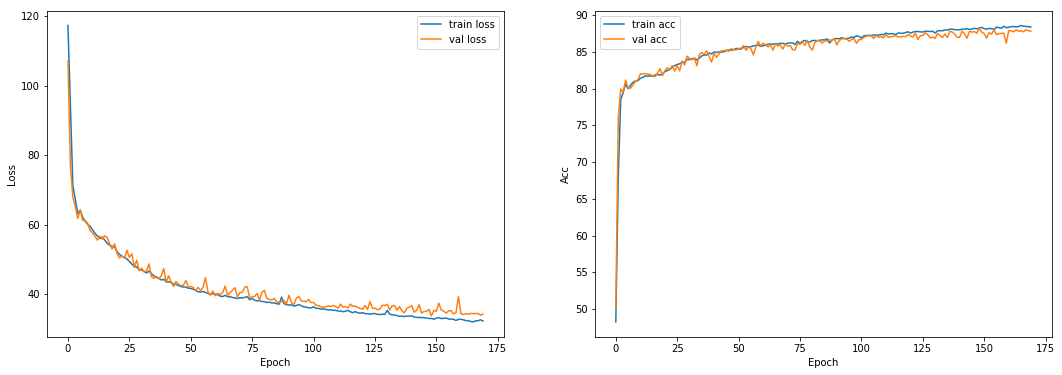

In [80]:
final_epochs = len(train_losses)
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))

axes[0].plot(range(final_epochs), train_losses, label = 'train loss')
axes[0].plot(range(final_epochs), val_losses, label = 'val loss')
axes[0].set_xlabel('Epoch') 
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(range(final_epochs), train_accs, label = 'train acc')
axes[1].plot(range(final_epochs), val_accs, label = 'val acc')
axes[1].set_xlabel('Epoch') 
axes[1].set_ylabel('Acc')
axes[1].legend()

# 5. test model

In [81]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
def testModel(XTestGender, XTestSeq, ytest, net): 
    net.eval()
    with torch.no_grad():
        outputs = net(XTestGender, XTestSeq).cpu()
    y_val = np.argmax(outputs, axis=1)   
    print(confusion_matrix(ytest,y_val))
    print(classification_report(ytest,y_val))
    print(accuracy_score(ytest, y_val))
    return confusion_matrix(ytest,y_val)
# def testModel(xtest, ytest, net): 
#     net.eval()
#     with torch.no_grad():
#         outputs = net(xtest)
#     _, y_val = outputs.max(-1)
#     correct = sum(y_val == ytest).item()
#     acc =  correct / len(y_val) * 100
#     return acc, correct
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [82]:
cnf_matrix = testModel(XTestGender, XTestSeq, YTest, LSTMmodel)

[[4504  128  175   25    5]
 [ 170 3807   21    2    0]
 [ 322   64  312   11    1]
 [ 122    5   15  167    0]
 [ 100    7    1    0   32]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      4837
           1       0.95      0.95      0.95      4000
           2       0.60      0.44      0.51       710
           3       0.81      0.54      0.65       309
           4       0.84      0.23      0.36       140

   micro avg       0.88      0.88      0.88      9996
   macro avg       0.81      0.62      0.67      9996
weighted avg       0.88      0.88      0.87      9996

0.8825530212084834


Normalized confusion matrix


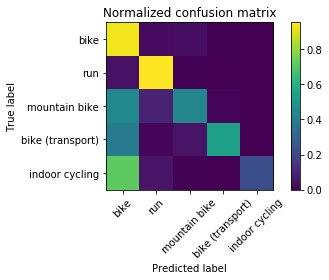

In [83]:
# Compute confusion matrix

np.set_printoptions(precision=2)
class_names = UsedClass
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [31]:
# checkpoint_path = 'checkpoint/LSTM/checkpoint.pth.tar'
# checkpoint = torch.load(checkpoint_path, map_location=LSTMmodel.device)
# LSTMmodel.load_state_dict(checkpoint['Net'])